In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool

from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F

def predict(x):
    a = -70
    b = 15
    #b = 10
    x_hat = a+b*np.log(x)
    if x_hat > x:
        x_hat=x/2
    if x_hat < 2:
        x_hat=2
    return(int(round(x_hat)))

qid = 6187

In [2]:
runs = RunStats.objects.filter(
    query=qid,
    limit=0,
    method = 'NM',
    error__gt=0,
    max_iter=200,
    alpha=0.01
).annotate(
    topics = models.Count('topic'),
)
df =  pd.DataFrame.from_dict(list(runs.values()))

In [3]:
df.head()

,K,alpha,batch_count,beta,citations,coherence,db,db_time,doc_topic_scaled_score,docs_seen,...,runtime,start,status,term_count,tfidf_time,top_chain_var,topic_scores_current,topic_titles_current,topic_year_scores_current,topics
0,110,0.01,0,None,False,0.205148,True,71357.712715,False,382311,...,NaT,2019-04-26 03:37:43.701947+00:00,3,18135,8609.048403,0.05,False,False,False,110
1,90,0.01,0,None,False,0.194795,True,27281.217024,False,382311,...,NaT,2019-04-24 21:34:46.872059+00:00,3,18135,7805.669504,0.05,False,False,False,90
2,140,0.01,0,None,False,0.205710,True,159714.843422,False,378291,...,NaT,2019-05-06 15:04:05.080416+00:00,3,18054,8261.578681,0.05,True,False,False,140
3,130,0.01,0,None,False,0.206629,True,69046.482284,False,378248,...,NaT,2019-04-28 04:11:06.406091+00:00,3,18055,7150.772383,0.05,False,False,False,130
4,120,0.01,0,None,False,0.210703,True,55088.239197,False,378248,...,NaT,2019-04-27 07:01:05.406127+00:00,3,18055,7422.228168,0.05,False,False,False,120


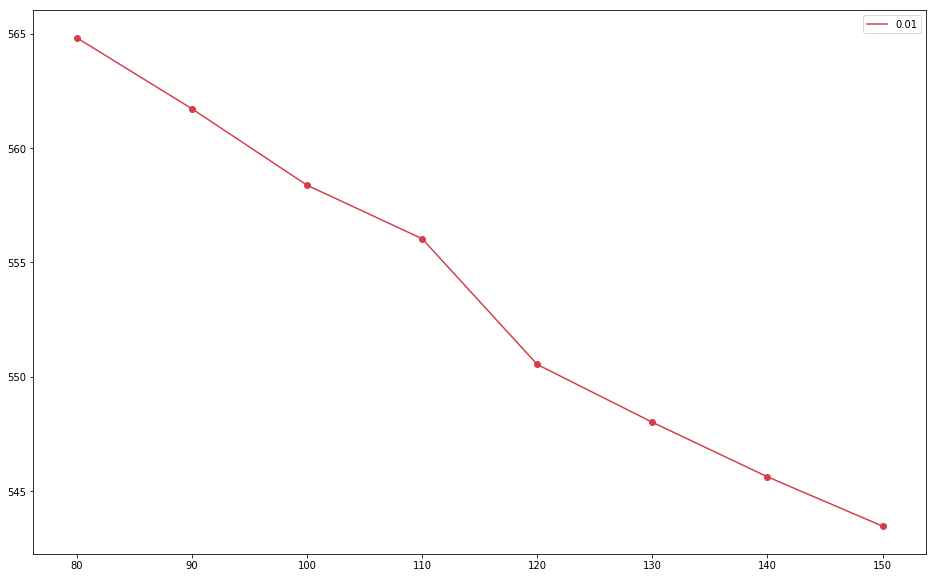

In [4]:
ndf = df.sort_values(by='topics', ascending=1).reset_index(drop=True)

colorset=["#d53e4f","#f46d43","#fdae61","#fee08b","#e6f598","#abdda4","#66c2a5","#3288bd"]
plt.rcParams["figure.figsize"] = [16,10]
gndf = ndf.groupby(['alpha'])
ps = []
gs = []
i = 0
for name,group in gndf:
    if name == 0.1:
        continue
    group = group.sort_values('K')
   # group = group[(group['K'] > 90) & (group['K'] < 150)]
    p = plt.plot(group['K'],group['error'],color=colorset[i])
    plt.scatter(group['K'],group['error'],color=colorset[i])
    #plt.scatter(group['K'],group['error']+group['empty_topics'],color=colorset[i])
    #m = group[group['topics']==150]
   # plt.text(
   #     m['topics'],
   #     m['error'],name
   # )
    ps.append(p[0])
    gs.append(name)
    i+=1
#p1 = plt.plot(ndf['topics'],ndf[ndf[max_features==5000]]['error'],color='#fbb4ae')
#p2 = plt.plot(ndf['topics'],ndf['iterations'],color='#b3cde3')
plt.legend((ps),(gs))

plt.savefig('../plots/optimal_k_{}.png'.format(qid),bbox_inches='tight')   

plt.show()

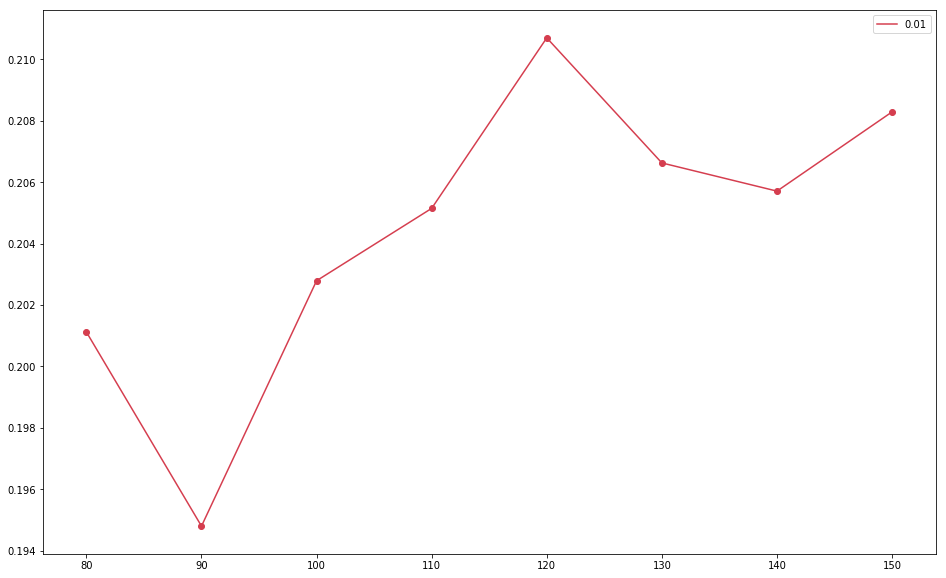

In [5]:
ndf = df.sort_values(by='topics', ascending=1).reset_index(drop=True)

colorset=["#d53e4f","#f46d43","#fdae61","#fee08b","#e6f598","#abdda4","#66c2a5","#3288bd"]
plt.rcParams["figure.figsize"] = [16,10]
gndf = ndf.groupby(['alpha'])
ps = []
gs = []
i = 0
for name,group in gndf:
    if name == 0.1:
        continue
    group = group.sort_values('K')
   # group = group[(group['K'] > 90) & (group['K'] < 150)]
    p = plt.plot(group['K'],group['coherence'],color=colorset[i])
    plt.scatter(group['K'],group['coherence'],color=colorset[i])
    #plt.scatter(group['K'],group['error']+group['empty_topics'],color=colorset[i])
    #m = group[group['topics']==150]
   # plt.text(
   #     m['topics'],
   #     m['error'],name
   # )
    ps.append(p[0])
    gs.append(name)
    i+=1
#p1 = plt.plot(ndf['topics'],ndf[ndf[max_features==5000]]['error'],color='#fbb4ae')
#p2 = plt.plot(ndf['topics'],ndf['iterations'],color='#b3cde3')
plt.legend((ps),(gs))

plt.savefig('../plots/optimal_k_coherence_{}.png'.format(qid),bbox_inches='tight')   

plt.show()

In [6]:
ar_qs = Query.objects.filter(project=23,title__icontains="climate all AR").order_by('id')
ar_qs

<QuerySet [<Query: climate all AR1>, <Query: climate all AR2>, <Query: climate all AR3>, <Query: climate all AR4>, <Query: climate all AR5>, <Query: climate all AR6>]>

climate all AR1


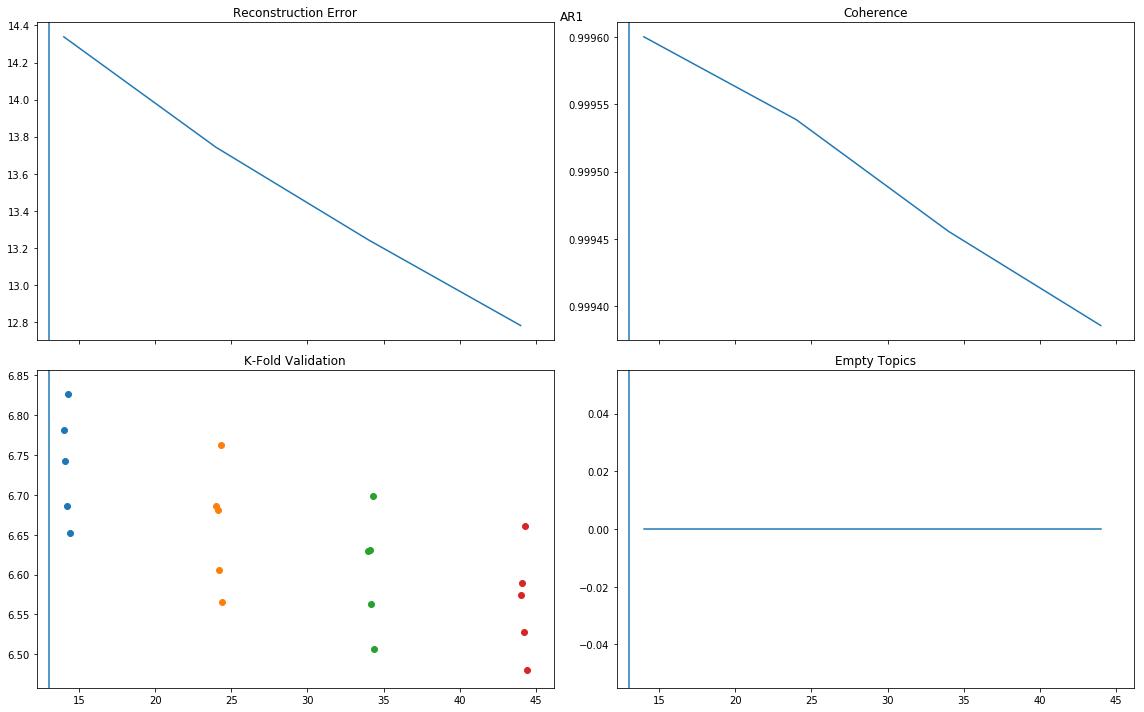

climate all AR2


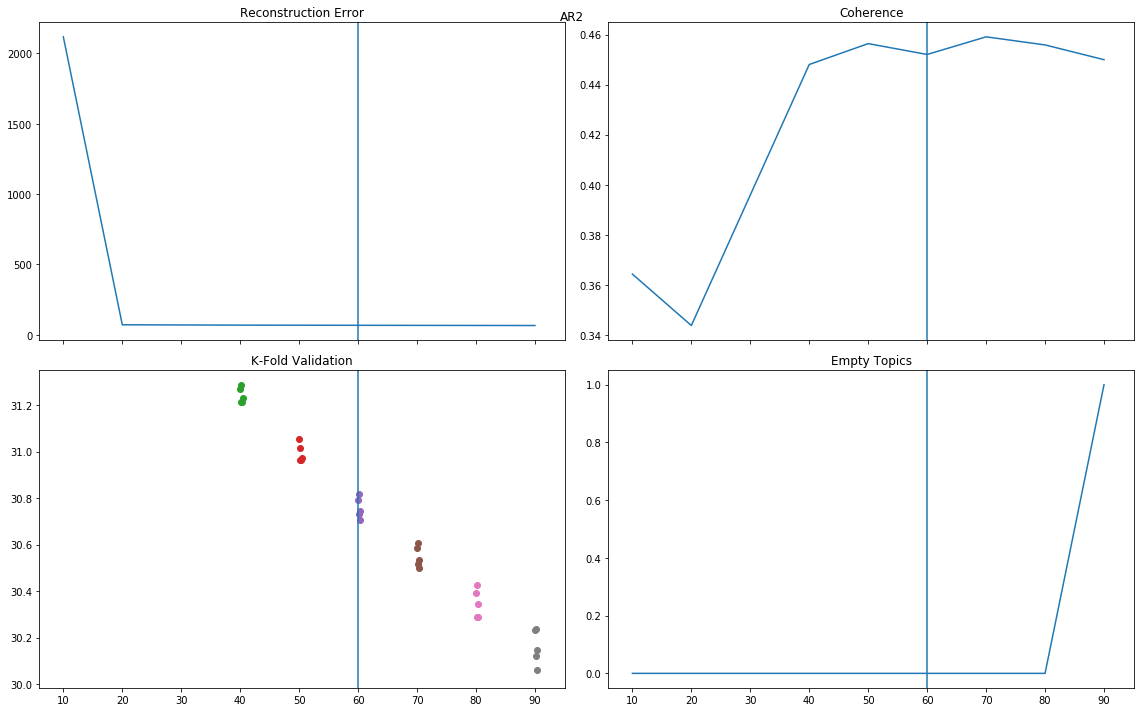

climate all AR3


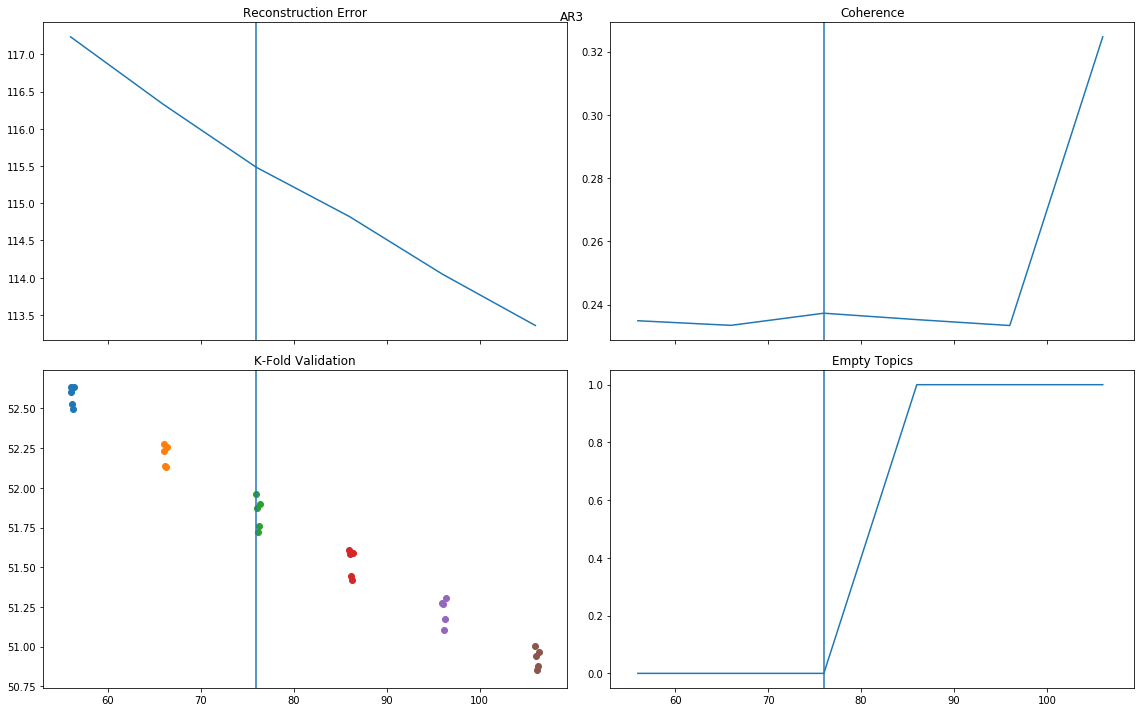

climate all AR4


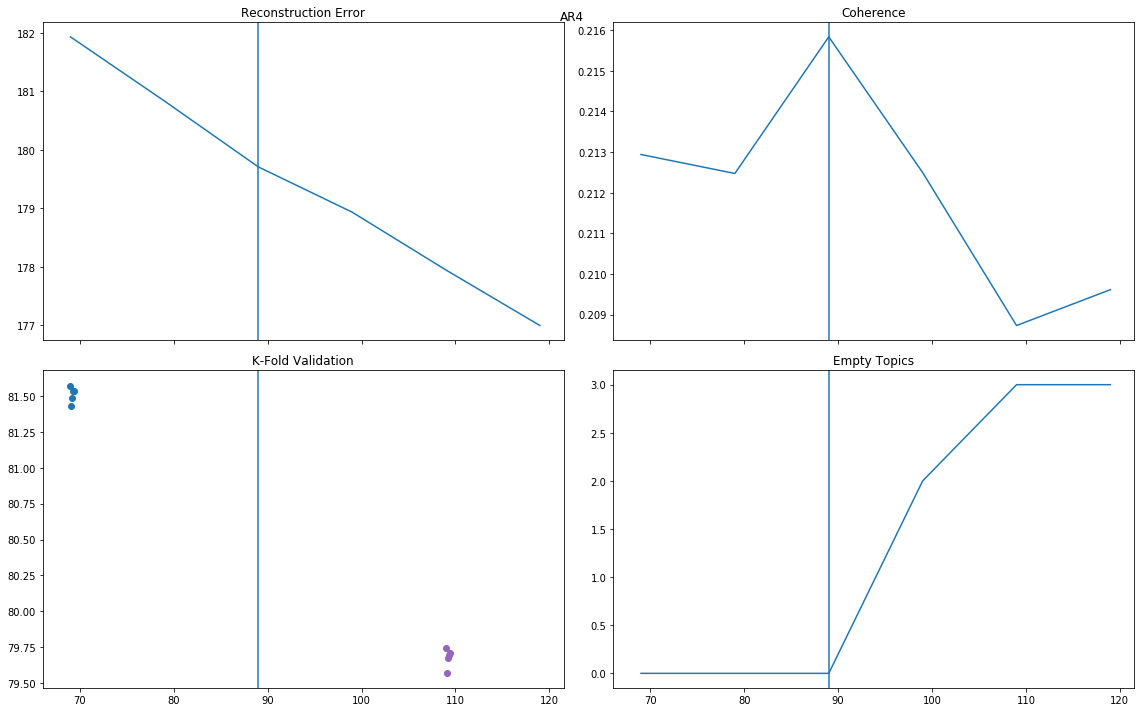

climate all AR5


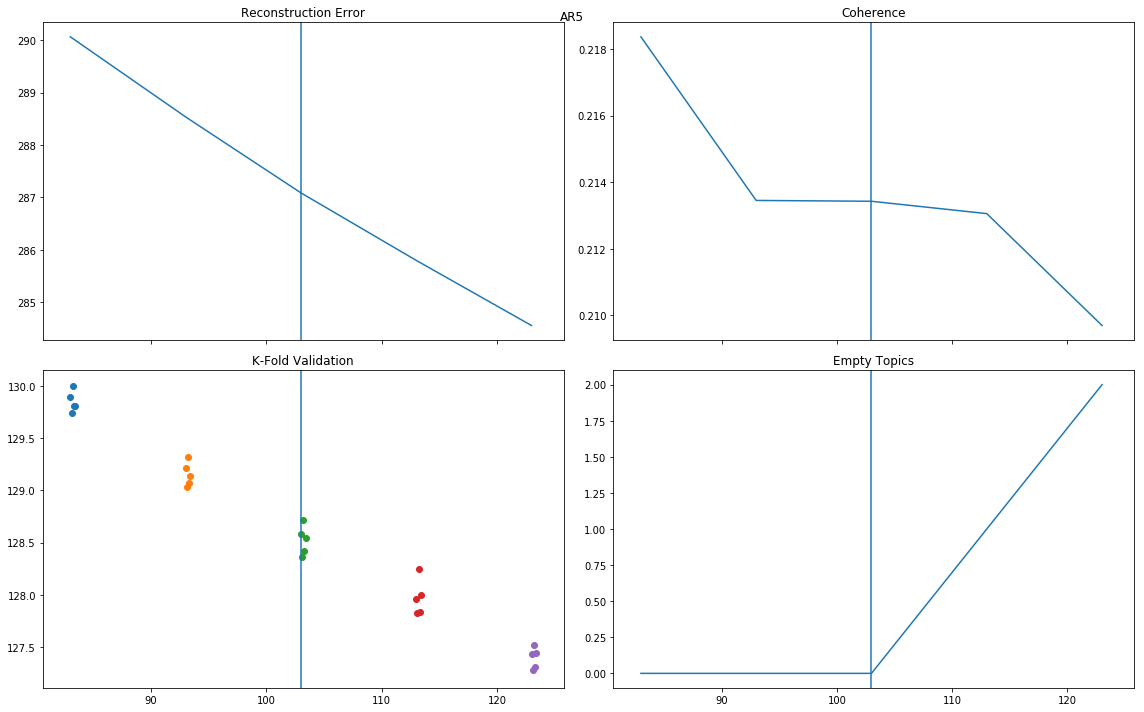

In [7]:
for q in ar_qs:
    if "AR6" in q.title:
        continue
    docs = Doc.objects.filter(query=q,content__iregex='\w')
    ydocs = docs.count()
    
    runs = RunStats.objects.filter(query=q,status=3).order_by('K')
    print(q.title)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True)
    ax1.plot(
        [x.K for x in runs],
        [x.error for x in runs]
    )
    ax1.set_title('Reconstruction Error')
    ax2.plot(
        [x.K for x in runs],
        [x.coherence for x in runs]
    )
    ax2.set_title('Coherence')
    ax4.plot(
        [x.K for x in runs],
        [x.empty_topics for x in runs]
    )
    ax4.set_title('Empty Topics')
    for s in runs:
        kfs = KFold.objects.filter(model=s)
        k = [s.K + x.K*0.1 for x in kfs]
        ax3.scatter(
            k,
            [x.error for x in kfs]
        )
    ax3.set_title('K-Fold Validation')
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axvline(predict(ydocs))
    fig.tight_layout()
    plt.suptitle(q.title.replace("climate all ",""))
    plt.savefig('../plots/topic_validations_{}.png'.format(q.title.replace("climate all ","")),bbox_inches='tight')  
    plt.show()

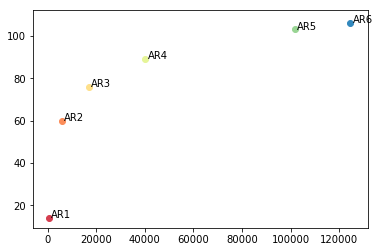

In [78]:
crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD"]
#crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']
for i,q in enumerate(ar_qs):
    docs = Doc.objects.filter(query=q,content__iregex='\w')
    ydocs = docs.count()
    
    plt.scatter(ydocs,predict(ydocs),color=crange[i])
    plt.text(ydocs+1000,predict(ydocs),s=q.title.replace("climate all ",""))

#plt.save_fig
plt.savefig('../plots/n_topics.png',bbox_inches='tight')   
plt.show()

In [59]:
print(q.title)
docs = Doc.objects.filter(query=q,content__iregex='\w')
ydocs = docs.count()
print(ydocs)

climate all AR6
38545


In [60]:
predict(ydocs)

88

<QuerySet [{'error': 30.5847830204175, 'K': 0, 'model_id': 524, 'id': 2}, {'error': 30.5177199769638, 'K': 1, 'model_id': 524, 'id': 3}, {'error': 30.6080864129655, 'K': 2, 'model_id': 524, 'id': 4}, {'error': 30.4973183232917, 'K': 3, 'model_id': 524, 'id': 5}, {'error': 30.5347941125892, 'K': 4, 'model_id': 524, 'id': 6}]>
[70.0, 70.1, 70.2, 70.3, 70.4]
<QuerySet [{'error': 30.3910231865348, 'K': 0, 'model_id': 525, 'id': 7}, {'error': 30.2882224893881, 'K': 1, 'model_id': 525, 'id': 8}, {'error': 30.4254350551367, 'K': 2, 'model_id': 525, 'id': 9}, {'error': 30.2892174174347, 'K': 3, 'model_id': 525, 'id': 10}, {'error': 30.3439046097313, 'K': 4, 'model_id': 525, 'id': 11}]>
[80.0, 80.1, 80.2, 80.3, 80.4]
<QuerySet [{'error': 30.2333439176156, 'K': 0, 'model_id': 526, 'id': 12}, {'error': 30.1192123735196, 'K': 1, 'model_id': 526, 'id': 13}, {'error': 30.2359656577344, 'K': 2, 'model_id': 526, 'id': 14}, {'error': 30.0599344190755, 'K': 3, 'model_id': 526, 'id': 15}, {'error': 30.14

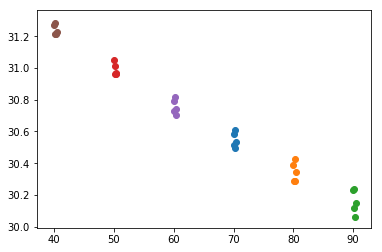

In [24]:
q = Query.objects.get(pk=1984)
stats = RunStats.objects.filter(query=q)
for s in stats:
    kfs = KFold.objects.filter(model=s)
    print(kfs.values())
    k = [s.K + x.K*0.1 for x in kfs]
    plt.scatter(
        k,
        [x.error for x in kfs]
    )
    print(k)
plt.show()